In [2]:
import numpy as np
import pandas as pd
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from urllib.parse import urlparse
import requests
import json
import os

In [3]:
ground_data_query_response = requests.get('http://127.0.0.1:8000/queryMeasurements', params={'datetime_from': datetime.datetime(2022, 11, 10), 'datetime_to': datetime.datetime(2022, 11, 20)})
assert ground_data_query_response.status_code == 200, f"Expected status_code 200, but got {ground_data_query_response.status_code}"

In [4]:
ground_data_json = ground_data_query_response.json()
print(type(ground_data_json))
print(str(ground_data_json)[:1000])

<class 'dict'>
{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'date': '2022-11-11', 'latitude': 1.1902236766224783, 'longitude': -97.7528864289593, 'temperature': 8.154448344359494}, 'geometry': {'type': 'Point', 'coordinates': [-97.7528864289593, 1.1902236766224783]}}, {'type': 'Feature', 'properties': {'date': '2022-11-11', 'latitude': 77.51074211650966, 'longitude': -15.539237271820062, 'temperature': -19.43282730209568}, 'geometry': {'type': 'Point', 'coordinates': [-15.539237271820062, 77.51074211650966]}}, {'type': 'Feature', 'properties': {'date': '2022-11-11', 'latitude': 57.98357205823524, 'longitude': -178.8117310653042, 'temperature': 26.654848553666383}, 'geometry': {'type': 'Point', 'coordinates': [-178.8117310653042, 57.98357205823524]}}, {'type': 'Feature', 'properties': {'date': '2022-11-11', 'latitude': -37.78520156942632, 'longitude': 107.67412230499508, 'temperature': 36.95420746702786}, 'geometry': {'type': 'Point', 'coordinates': [107

In [5]:
ground_data = gpd.GeoDataFrame.from_features(ground_data_json['features'])
locations = ground_data.drop_duplicates('geometry')
locations = locations[['longitude', 'latitude', 'geometry']]
print(len(locations))
print(locations)

12
     longitude   latitude                      geometry
0   -97.752886   1.190224     POINT (-97.75289 1.19022)
1   -15.539237  77.510742    POINT (-15.53924 77.51074)
2  -178.811731  57.983572   POINT (-178.81173 57.98357)
3   107.674122 -37.785202   POINT (107.67412 -37.78520)
4   -76.358613   4.653225     POINT (-76.35861 4.65322)
5    56.393806  42.480052     POINT (56.39381 42.48005)
6   163.953316 -16.855733   POINT (163.95332 -16.85573)
7  -154.145537 -28.530543  POINT (-154.14554 -28.53054)
8    27.278988  19.901985     POINT (27.27899 19.90199)
9    71.639263  66.363442     POINT (71.63926 66.36344)
10   35.666487   4.689949      POINT (35.66649 4.68995)
11  -65.691344 -48.004978   POINT (-65.69134 -48.00498)


In [6]:
locations_json = json.loads(locations.to_json())

In [9]:
sentinel_data_query_response = requests.post('http://127.0.0.1:8001/queryContainingGeometry', json=locations_json)
assert sentinel_data_query_response.status_code == 200, f"Expected status_code 200, but got {sentinel_data_query_response.status_code}"

In [10]:
grid_cells_json = sentinel_data_query_response.json()
print(type(grid_cells_json))
print(str(grid_cells_json)[:1000])

<class 'dict'>
{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'Description': 'TILE PROPERTIES<br><table border=0 cellpadding=0 cellspacing=0  width=250 style="FONT-SIZE: 11px; FONT-FAMILY: Verdana, Arial, Helvetica, sans-serif;"><tr><td bgcolor="#E3E1CA" align="right"><font COLOR="#000000"><b>TILE_ID</b></font></td><td bgcolor="#E4E6CA"> <font COLOR="#008000">01VCE</font></td></tr><tr><td bgcolor="#E3E1CA" align="right"><font COLOR="#000000"><b>EPSG</b></font></td><td bgcolor="#E4E6CA"> <font COLOR="#008000">32601</font></td></tr><tr><td bgcolor="#E3E1CA" align="right"><font COLOR="#000000"><b>MGRS_REF</b></font></td><td bgcolor="#E4E6CA"> <font COLOR="#008000">58.594230092 179.55830037 58.628771049 -178.72219325 57.730986809 -178.67931235 57.69762571 179.64384649</font></td></tr><tr><td bgcolor="#E3E1CA" align="right"><font COLOR="#000000"><b>UTM_WKT</b></font></td><td bgcolor="#E4E6CA"> <font COLOR="#008000">MULTIPOLYGON(((300000 6500040,300000 6390240,

In [11]:
grid_cells = gpd.GeoDataFrame.from_features(grid_cells_json['features'])
print(grid_cells)

                                             geometry  \
0   GEOMETRYCOLLECTION Z (POLYGON Z ((180.00000 57...   
1   GEOMETRYCOLLECTION Z (POLYGON Z ((-155.03407 -...   
2   GEOMETRYCOLLECTION Z (POLYGON Z ((-98.10092 1....   
3   GEOMETRYCOLLECTION Z (POLYGON Z ((-76.80509 5....   
4   GEOMETRYCOLLECTION Z (POLYGON Z ((-66.32849 -4...   
5   GEOMETRYCOLLECTION Z (POLYGON Z ((-19.43778 78...   
6   GEOMETRYCOLLECTION Z (POLYGON Z ((26.99981 20....   
7   GEOMETRYCOLLECTION Z (POLYGON Z ((34.80473 5.4...   
8   GEOMETRYCOLLECTION Z (POLYGON Z ((55.76569 43....   
9   GEOMETRYCOLLECTION Z (POLYGON Z ((71.26621 66....   
10  GEOMETRYCOLLECTION Z (POLYGON Z ((107.24791 -3...   
11  GEOMETRYCOLLECTION Z (POLYGON Z ((107.62871 -3...   
12  GEOMETRYCOLLECTION Z (POLYGON Z ((163.12842 -1...   

                                          Description   Name  
0   TILE PROPERTIES<br><table border=0 cellpadding...  01VCE  
1   TILE PROPERTIES<br><table border=0 cellpadding...  05JLJ  
2   TILE PRO

In [12]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [13]:
output_dir = 'results/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

C:\Users\erikw\anaconda3\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\erikw\anaconda3\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\erikw\AppData\Local\Temp\ipykernel_14120\2206605534.py:5: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(locations.longitude, locations.latitude, marker='x', s=10, linewidth=0.5, color='#E74C3C', edgecolor='white', zorder=3)


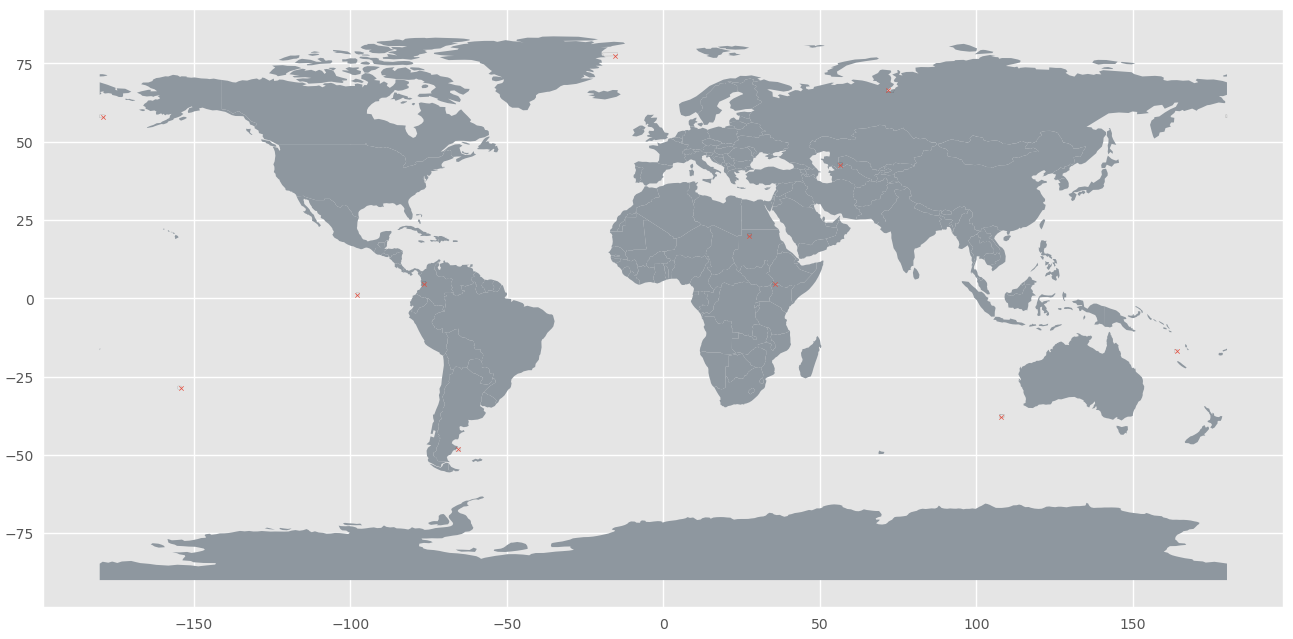

In [14]:
with plt.style.context(("seaborn", "ggplot")):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(16,9), color='#8e979f', zorder=1);
    grid_cells.buffer(0).boundary.plot(ax=ax, edgecolor='black', alpha=0.6, linewidth=0.1, zorder=2)
    ax.scatter(locations.longitude, locations.latitude, marker='x', s=10, linewidth=0.5, color='#E74C3C', edgecolor='white', zorder=3)
    plt.savefig(f'{output_dir}locations_and_grid_cells_view.svg', bbox_inches='tight', dpi=150, format='svg')